# SCDAA Coursework


### --Method of Successive Approximation (MSA)

---

#### **Di He, ID: s2184697, individual contribution percentage:51%**<br>
#### **Hengsong Kou, ID: s2183601, individual contribution percentage:49%** 

##Import package

In [ ]:
import numpy as np

from numpy.polynomial.hermite_e import hermevander
from numpy.polynomial.hermite_e import hermefit
from scipy import stats

import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.random.seed(42)

#Q1 Conditional expectation

---



From the lecture note of A.40, we could know how  to generate two dependent variables.



*  We need to define the two F-measurable, integrable and independent variables of $X$ and $Z$, then let $Y= f(X) + g(Z)$, where $f$ and $g$ are some deterministic functions. Then we will have the dependent variables of $X$ and $Y$.

Then from the coursework, we know how to calculat the estimates of Conditional Expectations.

*  First, we have two dependent variables of $X$ and $Y$.

*  Then, we could use Hermit polynomial $\psi_r(X)$ to transform the variable func$X$, where $r$ is the order of Hermit polynomial. Thart could use fuction of 'hermevander(X, hermiteOrder)' in Python to finish.

*  Besides, we know to use fuction $\frac{1}{N^2}\sum_{i=1}^N|y_i - \sum_{r=1}^M\beta_r\psi_r(x_i)|^2 $ to get the optimal $\beta_r$. But when we get the sample of N, the term of $\frac{1}{N^2}$ is a constant, so we do not need to care about that. We only need to consider about finding the the optimal value of $\beta_r$ to min $\sum_{i=1}^N|y_i - \sum_{r=1}^M\beta_r\psi_r(x_i)|^2 $ 

*  Finally, we could use Least squares estimation takes the solution to this problem.

Finally, when we have the value of the beta, we could use the function $\hat{y_i} = \beta\psi(x_i)$ to get the estimates of conditional expectations.

In [ ]:
def coeffsForCondiExp(X, Y, hermiteOrder):
  '''
  Inputs three parameters: Random variables X,Y and the order of Hermite

  Return some coefficients about the fitting function
  '''

  # Get the new data of X
  her_X = hermevander(X, hermiteOrder)

  # Use the function to get the coefficients
  coefficients = np.linalg.lstsq(her_X, Y, rcond=None)[0]

  return coefficients


def approxCondExp(X, beta):
  '''
  Inputs two parameters: Random variables X, fitted beta value, hermiteOrder

  Outputs: the predited value of Y
  '''

  hermiteOrder = len(beta)-1

  # Get the new data of X
  her_X = hermevander(X, hermiteOrder)

  # Calculate the value of predited Y
  Y_pred = her_X@beta.T

  return Y_pred

## Test data

We set some data to verify the fucntions of conditional expectation by using the value of MSE.

In [ ]:
# Test
# Give the random variable of X
X = np.random.randn(1000)

# Get 1000 random variable of Z
Z = np.random.uniform(low=0.0, high=1.0, size=(1000))

#
Y = X + Z

# Get the coefficients from the function
coefficients = coeffsForCondiExp(X, Y, 20)

# Get the expectation value
Y_pred = approxCondExp(X, coefficients)

# calculate the theoretical expectation
Expectation = X + 1

# Calculate MSE for testing the function
MSE = np.mean((Y_pred - Expectation)**2)

print('The MSE for the expectation is: {}'.format(MSE))

The MSE for the expectation is: 0.24752136114688614


#Q2 Solving a BSDE numerically
---
For part two, we use the formula (8) to write a iteration. after we set the initial value of risky asset price $S_0$, we can use the iteration to find the $Y_t$ which is a Numerical solution the BSDE equation.

###Steps:


*   1.We first set the initial value of risky asset price $S_0$.
*   2.Set all the parameter, such as Stock volatility and average rate of return $\mu$ and $σ$; Call option's exercise price; the total time $T$ ;The number of time steps $N$; the risk free interest rate $r$.
*   3.Generate the $ΔW_t$, and use the Euler scheme approximation (forward) to calculate the $S_T$.
*   4.Use the payoff function: $\xi =[S_T - K]_+$ to calculate the $\xi$.
*   5.Set $Y_T = \xi$
*   6.By the function: $Z_{T-1} ≈ \frac{1}{Δt_{T}}E_{t_{T-1}}[Y_{T} ΔW_{T}] $ and $Y_{T-1} ≈ E_{T-1}[Y_{T} - g_{T-1}(Y_T, Z_{T-1})Δt_T]$
*   7.Use this iteration to calculate Zt and the backward $Y_t $ for every $t = 0,1,...,T$
*   8.In our iteration, we use our functions defined in Q1(Empirical estimation of conditional expectation) to calculate the conditional expextation: $E_{t_{T-1}}[Y_{T} ΔW_{T}]$ and $E_{T-1}[Y_{T} - g_{T-1}(Y_T, Z_{T-1})Δt_T]$. The first expectation, we use the terms of $ΔW_{T}$ and $Y_{T} ΔW_{T}$ to calculcate the $β$. The second expectation, we use the terms of $ΔW_{T}$ and $Y_{T} - g_{T-1}(Y_T, Z_{T-1})Δt_T$ to calculcate the $β$
*   9.Repeat the process of iteration (STEP 6-8), then our iteration return a ndarray of $Y_t$'
*   10.Calculate the $Y_0-theoretical$ use the BS Model formula：

  $Price \quad of \quad option = S_T*N(d_1) - X*e^{(-rt)}*N(d_2)$

  where:
  $d_1 = ((lnS/X) + (r + 0.5*σ^2)t)/σ*sqrt(t)$
  and $d_2 = d_1 - σ*sqrt(t)$

  S = stock price, X = strike price, t = time, r = interest rate, $σ$ = volatility of stock price
  ,N(x) = standard normal cumulative distribution function

*   11.Calculate the mean square error of $Y_0-theoretical$ and $Y_0-simulation$(we calculate use our iteration)
*   12.Randomly choose and plot some path of the $Y_t$ array to check its convergence as in Figure 1.









In [ ]:
# Give a function to solve the BSDE
def BSDE(N_mc, hermiteOrder, sigma_st, mu_st, S0, K, T, N_step, r):
  '''
  function to solve the BSDE, and return the y_t and s_t
  '''
  #set parameters
  mu = mu_st
  sigma = sigma_st
  N = N_step
  # The length og time interval
  dt = T/N_step

  # Generate a random Wiener process interval
  sigma_w = np.sqrt(dt)

  # generate a sample of delta Wt from noraml(0,dt)
  rng = np.random.default_rng()
  dWt = sigma_w*rng.standard_normal(size=(N_mc,N_step))
  Wt = np.zeros((N_mc,N_step))
  sum_ = 0
  for i in range(N_step):
    sum_ += dWt[:,i]
    Wt[:,i] = sum_
  # St_list = []
  S0_ = np.ones(N_mc)*S0
  # St_list.append(S0_)
  # Simulating stock prices using Monte Carlo methods
  for i in range(N_step):
    ST = S0_ + S0_*mu*dt + S0_*sigma*dWt[:,i]
    S0_ = ST

  # Calculate the payoff at time T
  epsilon = np.array([max((ST[i]- K),0) for i in range(0, N_mc)])
  Y_ = epsilon

  # Set the total lists which are used to save the data we need
  Yt_total = []

  # Yt_total = Y_
  Yt_total.append(Y_)

  # Calcalulate the value of payoff at time 0
  for i in range(N_step):

    # Calculate the beta with Wt and Y*Wt
    beta_z =coeffsForCondiExp(Wt[:,-(i+1)], Y_*dWt[:,-(i+1)], hermiteOrder)

    # Calculate the value of Z
    Zt = approxCondExp(Wt[:,-(i+1)], beta_z)/dt

    # Calculate the vaule of g(Y,Z)
    y_mid = Y_ - dt*(r*Y_ + Zt*(mu-r)/sigma)

    # the beta of Wt and the vaule of g(Y,Z)
    beta_y = coeffsForCondiExp(Wt[:,-(i+1)], y_mid, hermiteOrder)

    # Generate analog value for Payoff
    Yt = approxCondExp(Wt[:,-(i+1)], beta_y)
    Yt_total.append(Yt)
    # Yt_total = np.append(Yt_total, Yt, axis=0)

    Y_ = Yt
  Y_0 = Y_ # this is the Y value at time 0

  return Yt_total, N_step, ST, Y_0

In [ ]:
# Calculate the error with Theoretical and simulated values for value of "Y_0"
def mse_cal(Yt_total, S0, K, r, T, sigma_st):
  '''
  function to calculate the mean square error of theoretical and simulated values for value of "Y_0"
  '''

  # Use BS formula to calculate the value of payoff at Time 0
  a = (np.log(S0/K) + (r+0.5*(sigma_st**2))*T)/(sigma_st*np.sqrt(T))
  b = a - sigma_st*np.sqrt(T)
  fai_a = stats.norm.cdf(a)
  fai_b = stats.norm.cdf(b)
  Y_theore = S0*fai_a - K * np.exp(-r*T)*fai_b 

  # Calculate the MSE
  mse_Y_0 = np.mean((Yt_total[-1] - Y_theore)**2)

  return mse_Y_0, Y_theore


we set the parameters of the model

In [ ]:
# Set of model
# Number of samples to sample
N_mc = 10000

# set the order of Hermit polynomial
hermiteOrder = 5

# Stock volatility and average rate of return
sigma_st = 0.1
mu_st = 0.045
# Initial stock price
S0 = 100
# Call option's exercise price
K = 100

# Set the total time T
T =0.1
# The number of time steps N
N_step = 100
#set values in the function of g(Y,Z)
r = 0.05

# test for convergence
Yt_total, N_step, ST, Y_0= BSDE(N_mc, hermiteOrder, sigma_st, mu_st, S0, K, T, N_step, r)

we plot a figure to see how dose Y_t converge with time t.

Text(0.5, 1.0, 'Figure 1-Yt Convergence Plot')

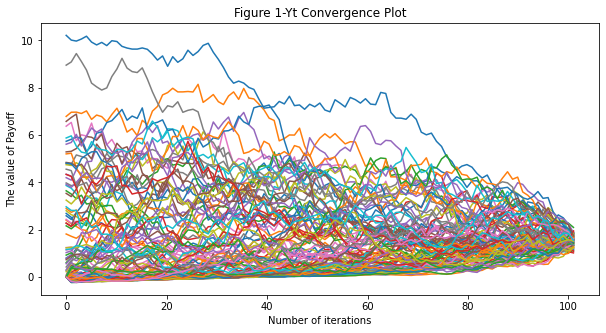

In [ ]:
# Drawing after shuffling the sampling path
Yt_total_np = np.array(Yt_total)
# Take the first N_chians chains to draw
N_chains = 100
col_Yt_total_np = np.arange(Yt_total_np.shape[1])
np.random.shuffle(col_Yt_total_np)
col_rand = Yt_total_np[:,col_Yt_total_np[0:N_chains]].T

# Set the x axis
x = np.linspace(0,N_step+1,num=N_step+1)

# Plot the figure of Yt Convergence Plot
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(N_chains):
  ax.plot(x, col_rand[i,:])

# Add an x-label to the axes.
ax.set_xlabel('Number of iterations')
# Add a y-label to the axes.  
ax.set_ylabel('The value of Payoff')
# Add a title to the axes.  
ax.set_title("Figure 1-Yt Convergence Plot")

In [ ]:
# Calculate the value of MSE and Theoretical Y0
MSE, Y_theore = mse_cal(Yt_total, S0, K, r, T, sigma_st)

print('MSE:{}'.format(MSE))

print('Theoretical Y0:{}',format(Y_theore))

MSE:0.04181817620209604
Theoretical Y0:{} 1.5234393853405948


###Analysis:


*   we plot the relationship between convergence and the number of basis functions $M$, in Figure 2.
*   we plot the relationship between convergence and the number of time steps $N$, in Figure 3.
*   we plot the relationship between convergence and the number of Monte Carlo samples $N_mc$, in Figure 4.


#### 1. Relationship between convergence and the number of basis functions M
---

To analysis how it depends on the number of basis functions M for convergence against the exact solution, we use the function of MSE(calculate the mean square error of numarical Y0 with its exact value) to calcualte the different errors with the different number of basis functions M.

Finally, in the Figure2, we find that the convergence is not depende on the number of basis functions M.



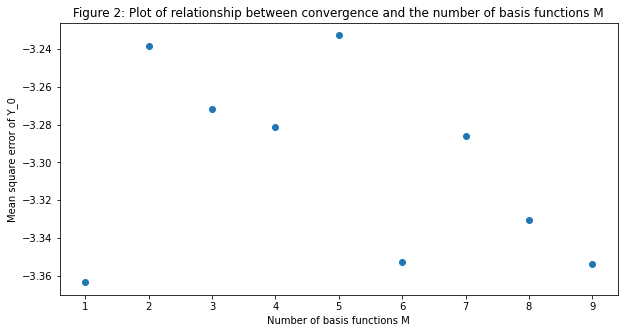

In [ ]:
# the relationship between convergence and the number of basis functions M

#set the N_mc and N_step
N_mc = 10000
N_step = 100

#calculate mse for each different M
mse_M = []
for hermiteOrder in range(1,10,1):
  Yt_total, N_step, ST, Y_0 = BSDE(N_mc, hermiteOrder, sigma_st, mu_st, S0, K, T, N_step, r)
  mse_M.append(mse_cal(Yt_total, S0, K, r, T, sigma_st)[0])

#plot the figure
x = list(range(1,10,1))
plt.figure(figsize=(10, 5))
plt.scatter(x, np.log(mse_M))
plt.title('Figure 2: Plot of relationship between convergence and the number of basis functions M')
plt.xlabel('Number of basis functions M')
plt.ylabel('Mean square error of Y_0')
plt.show()

#### 2. Relationship between convergence and the number of time steps N
---

To analysis how it depends on number of time steps N for convergence against the exact solution, we use the function of MSE(calculate the mean square error of numarical Y0 with its exact value) to calcualte the different errors with the different number of time steps N.

Finally, in the Figure3, we have the results that, as the number of time steps N increases, the error of our final result gradually decreases. Therefore, Yt gradually converge to the exact solution as number of time steps N increases.

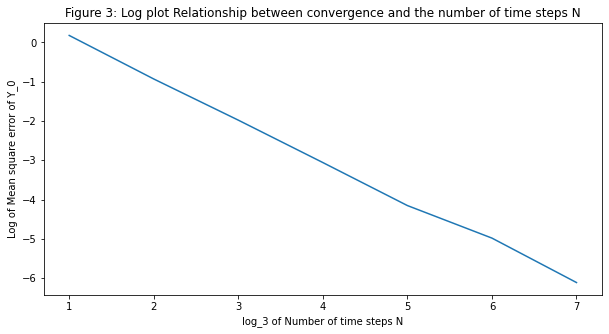

In [ ]:
# the relationship between convergence and the number of time steps N
# set parameters
N_mc = 10000
hermiteOrder = 5

# calculate the mse for each value of N_step
mse_N_step = []
x = list(range(1,8))
for i in x:
  N_step = 3**i
  Yt_total, N_step, ST, Y_0 = BSDE(N_mc, hermiteOrder, sigma_st, mu_st, S0, K, T, N_step, r)
  mse_N_step.append(mse_cal(Yt_total, S0, K, r, T, sigma_st)[0])

# plot the figure
plt.figure(figsize=(10,5))
plt.plot(x, np.log(mse_N_step))
plt.title('Figure 3: Log plot Relationship between convergence and the number of time steps N')
plt.xlabel('log_3 of Number of time steps N')
plt.ylabel('Log of Mean square error of Y_0')
plt.show()

#### 3. Relationship between convergence and the number of Monte Carlo samples N_mc

---



When we only adjust the number of Monte Carlo samples N_mc and fix the rest of parameters, we use the function of MSE to calcualte the different errors with the different number of Monte Carlo samples.

Finally, in this picture, we get the results that, as the number of Monte Carlo sampling increases, the error of our final result gradually decreases. Therefore, Yt gradually converge to the exact solution as number of Monte Carlo sampling increases.

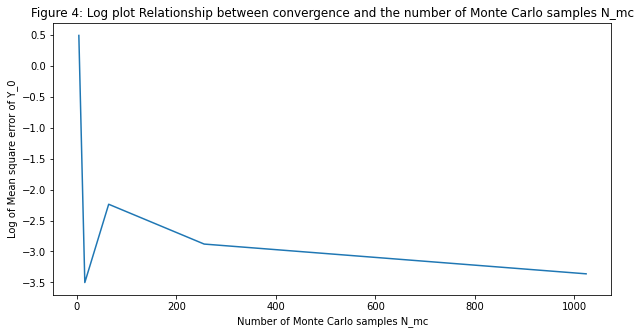

In [ ]:
# the relationship between convergence and the number of Monte Carlo samples N_mc
# set parameters
N_step = 100

# calculate the mse for each value of N_mc
mse_N_mc = []
x = list(range(1,6))
x_total = []
for i in x:
  N_mc = 4**i
  Yt_total, N_step, ST, Y_0 = BSDE(N_mc, hermiteOrder, sigma_st, mu_st, S0, K, T, N_step, r)
  mse_N_mc.append(mse_cal(Yt_total, S0, K, r, T, sigma_st)[0])
  x_total.append(N_mc)
# plot the figure
plt.figure(figsize=(10, 5))
plt.plot(x_total, np.log(mse_N_mc))
plt.title('Figure 4: Log plot Relationship between convergence and the number of Monte Carlo samples N_mc')
plt.xlabel('Number of Monte Carlo samples N_mc')
plt.ylabel('Log of Mean square error of Y_0')
plt.show()

# Q3 Deterministic MSA
---

## Theoretical Part

* (1) 

  We need to set up some parameters in our model. For example, the time T and the number of steps and coefficients in the model.

* (2) 
  
  From the lecture note, we know that 

  $dx_t = b(t,x,a)*dt = (L*x_t + M*a_t)*dt$;

  $dy_t =  -(L*y + 2*C*x + 2*F*a)*dt$;

  $f(t,x,a)=C*x_t^2 + D*a_t^2+2*x_t*F*a_t$;

  $g(x,t)=R*x_T^2$

  $H(x,y,a)=((L*X_t + M*a_t))*y+ C*x_t^2 + D*a_t^2+2*x_t*F*a_t$

  We need to make sure that the L, M, C, D, F, R to be constants, which is simple for us to calculate the model

* (3) 

  use the Euler method to calcalate of value of $x_t$:

  $x_{t+1}^{(j)} = x_{t}^{(j)} + (L*x_{t}^{(j)} + M*a_{t}^{(j-1)})*Δt$

  Then we could get the values of xt at each time.

* (4) 
  
  We from the function of $y_{T}^{(j)}=2*R*x_T$ to know the vaule of $y_T$

  Then, use the Euler method to calcalate of value of $y_t$:

  $y_{t}^{(j)} = y_{t+1}^{(j)} + (L*y_{t+1}^{(j)} + 2*C*x_{t+1}^{(j)} + 2*F*a_{t}^{(j-1)})*Δt$

* (5) 
  
  Now, we get the value of $x_{t}^{(j)}$, $y_{t}^{(j)}$, $a_{t}^{(j-1)}$, then we could use the 'scipy.optimize import minimize' to find the optimal actions at the value of $x_{t}^{(j)}$, $y_{t}^{(j)}$, $a_{t}^{(j-1)}$.

* (6)
  
  Then, we also use Euler method to calculate the value of running reward:

  $f(t+1,x,a) = f(t,x,a) + f(t,x,a)*Δt$

  Then, we get the whole value of running reward.

  Finally, use the function of $J = Running Reward + Terminal Reward$, so we get the value of $J^{a(j)}$.

* (7)
  
  Finally, we need to compare the value of $J^{a^{(j)}}$ with the value of $J^{a^{(j-1)}}$.

  If ϵ > $J^{a^{(j)}}$ - $J^{a^{(j-1)}}$, then we find the optimal action $a^{(j-1)}$
  

In [ ]:
# Define the function to calculate the max value of H to find the optimal action
def fun(args):
  '''
  function to define the function , which used in 'minimize function'
  '''

  L,M,C,D,F,x,y = args
  v = lambda action: -((L*x + M*action) * y + C*(x**2) + D*(action**2) + 2*x*F*action)
  return v

In [ ]:
# Define a function to calcualte the value of J
def MSA(T, N_step, x0, L, M, C, D, F, R):
  '''
  function to use MSA to find the optimal J for deterministic linear quadratic control

  '''

  # Calculate thedt
  dt = T/N_step

  # Set the initial action
  opti_set = np.zeros(N_step+1)

  # Set the value of epsilon
  epsilon = 0.0001

  # Set up a empty list to save the value of J
  J_list = []
  iteration=0
  while (iteration==0):

    # Set the array to save the values of x and y
    X_t = np.zeros(N_step+1)
    Y_t = np.zeros(N_step+1)
    X_t[0] = x0

    # 1. Calculate the value of x at the different time and action
    for i in range(1,N_step+1):
      X_t[i] = X_t[i-1] + (L*X_t[i-1] + M*opti_set[i-1]) * dt

    X_t = X_t.reshape(N_step+1,1)

    # 2. The value of y at time T
    y_last = 2*R*X_t[-1] 
    Y_t[0] = y_last
    # Calculate the value of y
    for i in range(1,N_step+1):
      Y_t[i] = Y_t[i-1] + (L*Y_t[i-1] + 2*C*X_t[N_step+1-i] + 2*F*opti_set[N_step+1-i])*dt

    Y_t = Y_t[::-1].reshape(N_step+1,1)


    # 3. action1
    # Calculate the optimal action with the X and Y in this term
    # Set a list to save the value of action
    optimal_action = []
    # Use the function to find the optimal function
    for x, y, action in zip(X_t, Y_t, opti_set):
      args = [L,M,C,D,F,x,y]
      res = minimize(fun(args), action, method='L-BFGS-B')
      optimal_action.append(res.x)
    optimal_action = np.array(optimal_action)

    # 4. Calculate J(a)
    # Calculate the value of J(a) with the next action
    F_integer = 0
    for i in range(N_step+1):
      F_integer += (C*(X_t[i]**2) + D*(optimal_action[i]**2) + 2*X_t[i]*F*optimal_action[i]) * dt
    J_action_initial =  F_integer + R*(X_t[-1]**2)

    print(f'J is :{J_action_initial}')
    J_list.append(J_action_initial)

    # Determine if this round is the first one
    if len(J_list) <= 1:
      # Reset the opti_set used in the next round
      opti_set = optimal_action
    
    # If not the first iteration
    else:

      # If the value of J satisify the condition
      if epsilon <= J_list[-1] - J_list[-2]:

        iteration = 0

        # Reset the opti_set used in the next round
        opti_set = optimal_action

      else:

        iteration = 1

  return X_t, optimal_action, J_list, dt

## Verification part
--- 
The exact solution:

Use Recatii numarical method to calculate the exact solution.

We guess $Y_t = 2*S(t)*X_t$

The function of $S(t)$ could be defined as:

$dS(t) = ((S(t)M(t) + F(t))*D(t)^{(-1)}*(M(t)^T*S(t) + F(t)^T) - L(t)*S(t) - S(t)*L(t) - C(t))*dt$

So we could get the values of $S(t)$ at each time t.


By using the values of $S(t)$, we could get the optimal action and optimal value of J

1. For the optimal action, we could use the fuction:

  $α_t = D(t)^{-1}(M(t)*S(t) +F(t))X_t$

2. For the optimal value of J in the lecture note:

  $J(x) = x(0) * S(0) * x(0)$

### The First Model：
---
The time is : T = 0.1

The number of steps: N_step = 1000

The initial value of x0: x0 = 2

The value of coefficients: L = 1, M = 1, C = -1, D = -1, F = 0, R = -1


**The results**:


1. **From comparing the exact action set and the numerical action set, we find that there is no difference here**.

2. **From ploting the figure of the exact J value and the numerical J value, we find that this algorithm is gradually convergent with exact values J. But in the middle there is a value of J that is greater than the exact value.**.

J is :[-5.92415839]
J is :[-4.67417391]
J is :[-4.80948495]


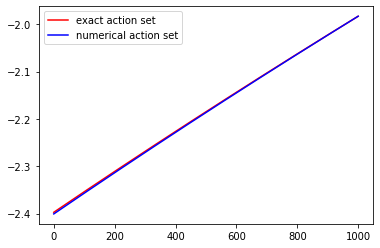



exact J value : -4.794716804412354


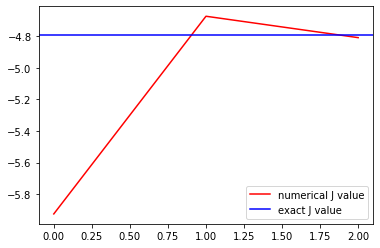

In [ ]:
# Model setiing
# Set the Time and the number of steps.
T = 0.1
N_step = 1000

# Set the initial x0
x0 = 2

# coefficients of model
L = 1
M = 1
C = -1
D = -1
F = 0
R = -1
# use MSA to find the optimal J
X_t, optimal_action, J_list, dt = MSA(T, N_step, x0, L, M, C, D, F, R)

# excat solution
# Calcualte the S(t)
S_t = np.zeros(N_step+1)
S_T = R
S_t[0] = S_T
for i in range(N_step):
  s_t = S_T - ((S_T*M + F)/D*(M*S_T + F) - L*S_T - S_T*L - C)*dt

  S_t[i+1] = s_t
  S_T = s_t
S_t = S_t[::-1].reshape(N_step+1,1)

# calculate the value of Yt by using S(t)
Y_t_hat =  2*S_t*X_t

# Calculate the value of exact action
exact_action_set_hat = (-M*Y_t_hat - 2*F*X_t)/(2*D)

# Plot the exact action and the numerical action
plt.plot(exact_action_set_hat, c='r', label = 'exact action set')
plt.plot(optimal_action, c='b', label = 'numerical action set')
plt.legend()
plt.show()

# Calcualte the exact J
J_exact = x0*S_t[0]*x0

print('\n')
print('exact J value : {}'.format(J_exact[0]))

J_list = np.array(J_list)

# Plot the exact J and the numerical J
plt.plot(range(J_list.shape[0]),J_list, c='r', label = 'numerical J value')
plt.axhline(J_exact[0], c='b', label = 'exact J value')
plt.legend()
plt.show()

### The Second Model：
---
The time is : T = 0.1

The number of steps: N_step = 1000

The initial value of x0: x0 = 2

The value of coefficients: L = 1, M = 1, C = -10, D = -10, F = 20, R = -0.1

---

#### Here, we change the value of coefficients in the problem setting, and we find that:


**The results**:

1. **From comparing the exact action set and the numerical action set, we find that there is no difference here**.

2. **From ploting the figure of the exact J value and the numerical J value, we find that this algorithm is gradually convergent with exact values J**.

J is :[12.78675171]
J is :[15.29804902]
J is :[15.80258654]
J is :[15.90388715]
J is :[15.92434123]
J is :[15.92847517]
J is :[15.92931081]
J is :[15.92947976]
J is :[15.9295139]


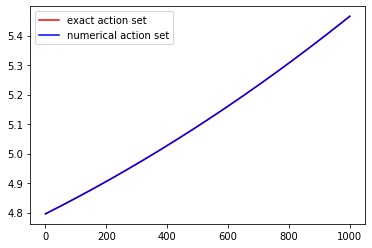



exact J value : 15.906001398468332


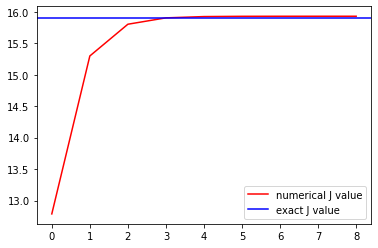

In [ ]:
# Model setiing
# Set the Time and the number of steps.
T = 0.1
N_step = 1000

# Set the initial x0
x0 = 2

# coefficients of model
L = 1
M = 1
C = -10
D = -10
F = 20
R = -0.1
# use MSA to find the optimal J
X_t, optimal_action, J_list, dt = MSA(T, N_step, x0, L, M, C, D, F, R)

# excat solution
# Calcualte the S(t)
S_t = np.zeros(N_step+1)
S_T = R
S_t[0] = S_T
for i in range(N_step):
  s_t = S_T - ((S_T*M + F)/D*(M*S_T + F) - L*S_T - S_T*L - C)*dt

  S_t[i+1] = s_t
  S_T = s_t
S_t = S_t[::-1].reshape(N_step+1,1)

# calculate the value of Yt by using S(t)
Y_t_hat =  2*S_t*X_t

# Calculate the value of exact action
exact_action_set_hat = (-M*Y_t_hat - 2*F*X_t)/(2*D)

# Plot the exact action and the numerical action
plt.plot(exact_action_set_hat, c='r', label = 'exact action set')
plt.plot(optimal_action, c='b', label = 'numerical action set')
plt.legend()
plt.show()

# Calcualte the exact J
J_exact = x0*S_t[0]*x0

print('\n')
print('exact J value : {}'.format(J_exact[0]))

J_list = np.array(J_list)

# Plot the exact J and the numerical J
plt.plot(range(J_list.shape[0]),J_list, c='r', label = 'numerical J value')
plt.axhline(J_exact[0], c='b', label = 'exact J value')
plt.legend()
plt.show()

### The Third Model：
---
The time is : T = 0.1

The number of steps: N_step = 100

The initial value of x0: x0 = 2

The value of coefficients: L = 1, M = 1, C = -10, D = -10, F = 20, R = -0.1

---

#### Here, we decrease the N_step, which is the parameter of MSA algorithm, we find that:

**The results**:

1. **From comparing the exact action set and the numerical action set, we find that the accurancy of actions is still good.**.

2. **From ploting the figure of the exact J value and the numerical J value, we find that this algorithm is gradually converge to a value J', which is 0.2 higher than the exact values J. The accurancy is decrease, but it still converge**.

J is :[12.90585856]
J is :[15.44047367]
J is :[15.94984432]
J is :[16.05204622]
J is :[16.07267485]
J is :[16.07684249]
J is :[16.07768459]
J is :[16.07785481]
J is :[16.07788921]


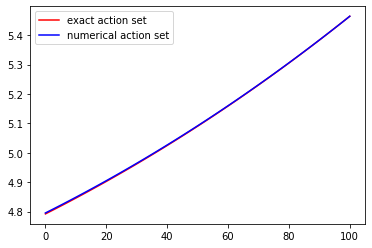



exact J value : 15.843068047774581


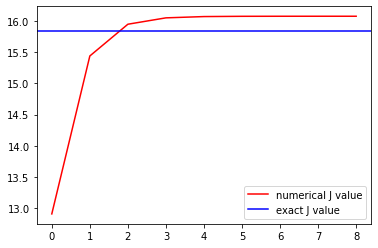

In [ ]:
# Model setiing
# Set the Time and the number of steps.
T = 0.1
N_step = 100

# Set the initial x0
x0 = 2

# coefficients of model
L = 1
M = 1
C = -10
D = -10
F = 20
R = -0.1
# use MSA to find the optimal J
X_t, optimal_action, J_list, dt = MSA(T, N_step, x0, L, M, C, D, F, R)

# excat solution
# Calcualte the S(t)
S_t = np.zeros(N_step+1)
S_T = R
S_t[0] = S_T
for i in range(N_step):
  s_t = S_T - ((S_T*M + F)/D*(M*S_T + F) - L*S_T - S_T*L - C)*dt

  S_t[i+1] = s_t
  S_T = s_t
S_t = S_t[::-1].reshape(N_step+1,1)

# calculate the value of Yt by using S(t)
Y_t_hat =  2*S_t*X_t

# Calculate the value of exact action
exact_action_set_hat = (-M*Y_t_hat - 2*F*X_t)/(2*D)

# Plot the exact action and the numerical action
plt.plot(exact_action_set_hat, c='r', label = 'exact action set')
plt.plot(optimal_action, c='b', label = 'numerical action set')
plt.legend()
plt.show()

# Calcualte the exact J
J_exact = x0*S_t[0]*x0

print('\n')
print('exact J value : {}'.format(J_exact[0]))

J_list = np.array(J_list)

# Plot the exact J and the numerical J
plt.plot(range(J_list.shape[0]),J_list, c='r', label = 'numerical J value')
plt.axhline(J_exact[0], c='b', label = 'exact J value')
plt.legend()
plt.show()

### The Fourth Model：
---
The time is : T = 0.1

The number of steps: N_step = 1000

The initial value of x0: x0 = 100

The value of coefficients: L = 1, M = 1, C = -10, D = -10, F = 20, R = -0.1


**The results**:

1. **From comparing the exact action set and the numerical action set, we find that there is no difference here**.

2. **From ploting the figure of the exact J value and the numerical J value, we find that this algorithm is gradually convergent with exact values J**.

J is :[31966.87906442]
J is :[38245.12249641]
J is :[39506.46672491]
J is :[39759.7171326]
J is :[39810.85360505]
J is :[39821.18782414]
J is :[39823.2761554]
J is :[39823.69794899]
J is :[39823.78726538]
J is :[39823.80316019]
J is :[39823.8047031]
J is :[39823.8060803]
J is :[39823.8057964]


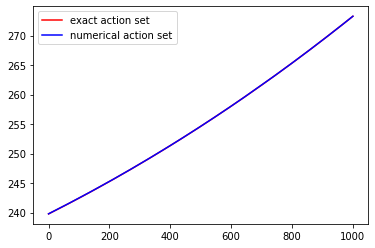



exact J value : 39765.00349617083


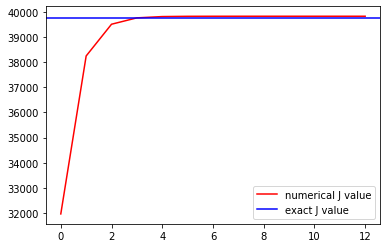

In [ ]:
# Model setiing
# Set the Time and the number of steps.
T = 0.1
N_step = 1000

# Set the initial x0
x0 = 100

# coefficients of model
L = 1
M = 1
C = -10
D = -10
F = 20
R = -0.1
# use MSA to find the optimal J
X_t, optimal_action, J_list, dt = MSA(T, N_step, x0, L, M, C, D, F, R)

# excat solution
# Calcualte the S(t)
S_t = np.zeros(N_step+1)
S_T = R
S_t[0] = S_T
for i in range(N_step):
  s_t = S_T - ((S_T*M + F)/D*(M*S_T + F) - L*S_T - S_T*L - C)*dt

  S_t[i+1] = s_t
  S_T = s_t
S_t = S_t[::-1].reshape(N_step+1,1)

# calculate the value of Yt by using S(t)
Y_t_hat =  2*S_t*X_t

# Calculate the value of exact action
exact_action_set_hat = (-M*Y_t_hat - 2*F*X_t)/(2*D)

# Plot the exact action and the numerical action
plt.plot(exact_action_set_hat, c='r', label = 'exact action set')
plt.plot(optimal_action, c='b', label = 'numerical action set')
plt.legend()
plt.show()

# Calcualte the exact J
J_exact = x0*S_t[0]*x0

print('\n')
print('exact J value : {}'.format(J_exact[0]))

J_list = np.array(J_list)

# Plot the exact J and the numerical J
plt.plot(range(J_list.shape[0]),J_list, c='r', label = 'numerical J value')
plt.axhline(J_exact[0], c='b', label = 'exact J value')
plt.legend()
plt.show()

## Conclusion for Deterministic Linear Quadratic control:
---
We set parameters of Linear Quadratic control to be constant.

We change the problem setting and parameters for many different values, but only four models above:
### Analysis:

(1)For the dependence of problem setting:
1. the numarical solution is very sensitive with parameters. For different parameters, the convergence rate , the accurancy of convergence optimal J will change a lot. 
2. the set of initial solution x0 will also affect the convergence rate and the accurancy of convergence optimal J.

(2).For the dependence of parameters choices:
1. we test the dependence of convergence and N_step, and find that, as N_step decrease, the optimal action not change a lot with differnet N_step, but the numarical optimal J values will lose accurancy. Most of time, the MSA is still convergent.

#Q4 Stochastic MSA
---

## Theoretical Part

* (1) 

  First we set up the parameters for our model: the time T; the number of steps; initial value $X^*$; initial action set and coefficients for Linear Quafratic problem.

* (2) 
  
  From the lecture note, we know that 

  $dx_t = b(t,x,a)*dt = (L*x_t + M*a_t)*dt + σ*dW_t$, with $X_0 = X^*$;

  $dy_t =  -(L*y + 2*C*x + 2*F*a)*dt + Z_t*dW_t$, with $Y_T = 2*R*X_T$;

  $f(t,x,a)=C*x_t^2 + D*a_t^2+2*x_t*F*a_t$;

  $g(x,t)=R*x_T^2$

  $H(x,y,z,a)=((L*X_t + M*a_t))*y+ σ*Z_t + C*x_t^2 + D*a_t^2+2*x_t*F*a_t$

  We need to make sure that the L, M, C, D, F, R and $\sigma $ to be constants, which is simple for us to calculate the model

* (3) 

  use the Euler method to calcalate of value of $x_t$:

  $x_{t+1}^{(j)} = x_{t}^{(j)} + (L*x_{t}^{(j)} + M*a_{t}^{(j-1)})*Δt + σ*ΔW_t$ 

  where $ΔW_t$ is generate from Normal(0,dt)

  Then we could get the values of xt at each time.

* (4) 
  
  We from the function of $y_{T}^{(j)}=2*R*x_T$ to know the vaule of $y_T$

  Then, use the Euler method to calcalate of value of $y_t$:

  By using method in Question 2 for solving the BSDE, we can solve the equation:

  $z_t^j \approx \frac{1}{Δt} * \mathbb{E}_{t_i}[Y_{t+1} ΔW_{t+1}]$

  $y_{t}^{(j)} = \mathbb{E}_{t_i}[y_{t+1}-(L*y_{t+1}^{(j)} + 2*C*x_{t+1}^{(j)} + 2*F*a_{t}^{(j-1)})*Δt]$

  with $y_{T}^{(j)}=2*R*x_T$

  Then we could get the values of yt at each time.
* (5) 
  
  Now, we get the value of $x_{t}^{(j)}$, $y_{t}^{(j)}$, $z_{t}^{(j)}$, $a_{t}^{(j-1)}$, then we could use the 'scipy.optimize.minimize' function to find the optimal actions at the value of $x_{t}^{(j)}$, $y_{t}^{(j)}$, $z_{t}^{(j)}$, $a_{t}^{(j-1)}$. for each $t = 0, 1, 2, 3, ... , T$ 

* (6)
  To calculate the $J^{a(j)}$, we use equation:

  $J = Running Reward + Terminal Reward$

  where 'Running Reward' = $∫^{T}_{0}f(t,x^{(j)}_t,a^{(j)}_t)*dt$, and 'Terminal Reward' = $f(x^{(j)}_T$

  Then, we also use Euler method to calculate the value of running reward:

  $f(t+1,x,a) = f(t,x,a) + f(t,x,a)*Δt$

  Then, we get the whole value of running reward.


* (7)
  
  Finally, we need to compare the value of $J^{a^{(j)}}$ with the value of $J^{a^{(j-1)}}$.

  If ϵ > $J^{a^{(j)}}$ - $J^{a^{(j-1)}}$, then we find the optimal action $a^{(j-1)}$
  

In [ ]:
def fun1(args):
  '''
  function to define the function , which used in 'minimize function'
  '''

  L,M,C,D,F,sigma,x,y,z = args
  v = lambda action: -((L*x + M*action) * y + sigma*z + C*(x**2) + D*(action**2) + 2*x*F*action)
  return v

In [ ]:
def MAS_Wt (T, N_step, N_mc, hermiteOrder, x0, L, M, C, D, F, R, sigma, dWt, Wt):
  
  '''
  function to use MSA to find the optimal J for deterministic linear quadratic control

  '''
  # Set the initial action
  opti_set = np.zeros((N_mc,N_step+1))
  # calculate the dt
  dt = T/N_step

  # Set the value of epsilon
  epsilon = 0.01
  J_list_mc = []
  iteration=0

  while(iteration == 0):

    #initial X_t
    X_t = np.zeros((N_mc,N_step+1))
    X_t[:,0] = x0
    # first time 
    # 1. calculate X_t
    for i in range(1,N_step+1):
      X_t[:,i] = X_t[:,i-1] + (L*X_t[:,i-1] + M*opti_set[:,i-1]) * dt + sigma * dWt[:,i-1]
    

    # 2. calculate Y_t
    # Calculate the payoff at time T
    Y_ = 2*R*X_t[:,-1]
    Z_ = np.zeros(N_mc)
    # Set the total lists which are used to save the data we need
    Yt_total = []
    Zt_total = []
    # Yt_total = Y_
    Yt_total.append(Y_)
    Zt_total.append(Z_)
    # Calcalulate the value of payoff at time 0
    for i in range(N_step):

      # Calculate the beta with Wt and Y*Wt
      beta_z =coeffsForCondiExp(Wt[:,-(i+1)], Y_*dWt[:,-(i+1)], hermiteOrder)

      # Calculate the value of Z
      Zt = approxCondExp(Wt[:,-(i+1)], beta_z)/dt
      Zt_total.append(Zt)
      # Calculate the vaule of g(Y,Z)
      y_mid = Y_ - dt*(-(L*Y_ + 2*C*X_t[:,N_step-i] + 2*F*opti_set[:,N_step-i]))

      # the beta of Wt and the vaule of g(Y,Z)
      beta_y = coeffsForCondiExp(Wt[:,-(i+1)], y_mid, hermiteOrder)

      # Generate analog value for Payoff
      Yt = approxCondExp(Wt[:,-(i+1)], beta_y)
      Yt_total.append(Yt)
      # Yt_total = np.append(Yt_total, Yt, axis=0)

      Y_ = Yt
    Y_0 = Y_
    Yt_total = Yt_total[::-1]
    Zt_total = Zt_total[::-1]
    # reshape the Yt_total, Zt_total
    Yt_total_nd = np.array(Yt_total)
    Y_t = Yt_total_nd.reshape(N_mc,N_step+1)

    Zt_total_nd = np.array(Zt_total)
    Z_t = Zt_total_nd.reshape(N_mc,N_step+1)

    # 3. calculate alphe
    optimal_action = []

    for i in range(N_step+1):
      for j in range(N_mc):
        args = [L,M,C,D,F,sigma,X_t[j,i],Y_t[j,i],Z_t[j,i]]
        action = opti_set[j,i]
        res = minimize(fun1(args), action, method='L-BFGS-B')
        optimal_action.append(res.x)
    optimal_action = np.array(optimal_action).reshape(N_step+1,N_mc).T

    #4. calculate J(a)
    # Calculate the value of J(a) with the next action
    F_integer = 0
    for i in range(N_step+1):
      F_integer += (C*(X_t[:,i]**2) + D*(optimal_action[:,i]**2) + 2*X_t[:,i]*F*optimal_action[:,i]) * dt
      # print(F)
    J_action_initial =  (F_integer + R*(X_t[:,-1]**2)).sum()/N_mc
    print(f'J is : {J_action_initial}')
    J_list_mc.append(J_action_initial)
    opti_set = optimal_action

    if len(J_list_mc) <= 1:
        # Reset the opti_set used in the next round
        opti_set = optimal_action
    else:
      if epsilon <= J_list_mc[-1] - J_list_mc[-2]:
        iteration = 0

        # Reset the opti_set used in the next round
        opti_set = optimal_action

      else:
        iteration = 1

  return J_list_mc



## Verification part
--- 

### The First Model：
---
The time is : T = 0.1

The number of steps: N_step = 1000

The number of steps: N_mc = 10

The initial value of x0: x0 = 2

The value of coefficients: L = 0, M = 1, C = 0, D = -1, F = 0, R = -1, σ = 0.1


**The results**:

1. **From ploting the figure of the exact J value and the numerical J value, we find that this algorithm is gradually converge to exact values J. But in the middle there is a value of J that is greater than the exact value.**.

J is : -4.408944974635998
J is : -3.5713605238832464
J is : -3.6511514251773725


exact J value : -3.637286176848546


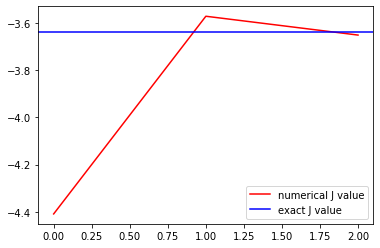

In [ ]:
# Model setiing
# set parameters
T = 0.1
N_step = 1000
N_mc = 10
dt = T/N_step
hermiteOrder = 5
# initial
x0 = 2
# coefficience
L = 0.   #L = A_T
M = 1.   #M = B_T
C = 0.   #C = Q_t
D = -1.  #D = -R_T
F = 0.   #F = 0
R = -1.  #R = -Q_T
sigma = 0.1

# Generate a random Wiener process interval
sigma_w = np.sqrt(dt)

# generate a sample of Wt
rng = np.random.default_rng()
dWt = sigma_w*rng.standard_normal(size=(N_mc,N_step))
Wt = np.zeros((N_mc,N_step))
sum_ = 0
for i in range(N_step):
  sum_ += dWt[:,i]
  Wt[:,i] = sum_
# then we calculate the numaricail J value by using functions abouve
J_list_mc = MAS_Wt (T, N_step, N_mc, hermiteOrder, x0, L, M, C, D, F, R, sigma, dWt, Wt)

# excat solution
S_t = np.zeros(N_step+1)
S_T = R
S_t[0] = S_T
for i in range(N_step):
  s_t = S_T - ((S_T*M + F)/D*(M*S_T + F) - L*S_T - S_T*L - C)*dt

  S_t[i+1] = s_t
  S_T = s_t
S_t = S_t[::-1].reshape(N_step+1,1)

#calculate the integer
int_sigma = 0
for i in range(N_step+1):
  int_sigma += sigma*sigma*S_t[i]*dt

J_exact = x0*S_t[0]*x0 + int_sigma

J_list_mc= np.array(J_list_mc)
print('\n')
print('exact J value : {}'.format(J_exact[0]))
#plot the figure of convergence
plt.plot(range(J_list_mc.shape[0]),J_list_mc, c='r', label = 'numerical J value')
plt.axhline(J_exact[0], c='b', label = 'exact J value')
plt.legend()
plt.show()

### The Second Model：
---
The time is : T = 0.1

The number of steps: N_step = 100

The number of steps: N_mc = 10

The initial value of x0: x0 = 2

The value of coefficients: L = 1, M = 1, C = -10, D = -10, F = 20, R = -0.1, σ = 0.001


**The results**:

1. **From ploting the figure of the exact J value and the numerical J value, we find that this algorithm is gradually converge to a value that a little above the exact values J**.

J is : 12.905075987159412
J is : 15.466841341152328
J is : 15.871380733131085
J is : 15.952348507434706
J is : 15.968760209512592
J is : 15.972081653944977


exact J value : 15.843068221473517


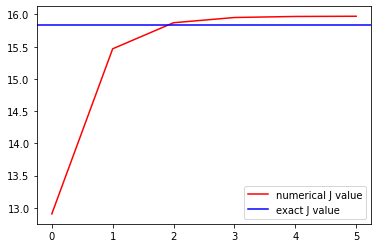

In [ ]:
# Model setiing
# set parameters
T = 0.1
N_step = 100
N_mc = 10
dt = T/N_step
hermiteOrder = 5
# initial
x0 = 2
# coefficience
L = 1
M = 1
C = -10
D = -10
F = 20
R = -0.1
sigma = 0.001

# Generate a random Wiener process interval
sigma_w = np.sqrt(dt)

# generate a sample of Wt
rng = np.random.default_rng()
dWt = sigma_w*rng.standard_normal(size=(N_mc,N_step))
Wt = np.zeros((N_mc,N_step))
sum_ = 0
for i in range(N_step):
  sum_ += dWt[:,i]
  Wt[:,i] = sum_
# then we calculate the numaricail J value by using functions abouve
J_list_mc = MAS_Wt (T, N_step, N_mc, hermiteOrder, x0, L, M, C, D, F, R, sigma, dWt, Wt)

# calculate the excat solution
S_t = np.zeros(N_step+1)
S_T = R
S_t[0] = S_T
for i in range(N_step):
  s_t = S_T - ((S_T*M + F)/D*(M*S_T + F) - L*S_T - S_T*L - C)*dt

  S_t[i+1] = s_t
  S_T = s_t
S_t = S_t[::-1].reshape(N_step+1,1)

#calculate the integer
int_sigma = 0
for i in range(N_step+1):
  int_sigma += sigma*sigma*S_t[i]*dt

J_exact = x0*S_t[0]*x0 + int_sigma

J_list_mc= np.array(J_list_mc)
print('\n')
print('exact J value : {}'.format(J_exact[0]))
#plot the figure of convergence
plt.plot(range(J_list_mc.shape[0]),J_list_mc, c='r', label = 'numerical J value')
plt.axhline(J_exact[0], c='b', label = 'exact J value')
plt.legend()
plt.show()

### The Third Model：
---
The time is : T = 0.1

The number of steps: N_step = 1000

The number of steps: N_mc = 10

The initial value of x0: x0 = 100

The value of coefficients: L = 1, M = 1, C = -10, D = -10, F = 20, R = -0.1, σ = 0.001


**The results**:


1. **Here we increase the N_step, and find that we reduce the difference about exact value J and numarical J' from 0.13 to 0.08. so increase the N_step can increase the accurancy about optimal J, but it cost more time to run the algorithm**.

J is : 12.786096094872928
J is : 15.323863652927823
J is : 15.726336003368937
J is : 15.80681671855944
J is : 15.823134264497565
J is : 15.826437983926951


exact J value : 15.90600157105608


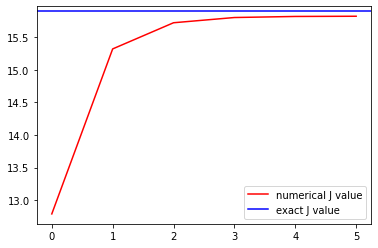

In [ ]:
# Model setiing
# set parameters
T = 0.1
N_step = 1000
N_mc = 10
dt = T/N_step
hermiteOrder = 5
# initial
x0 = 2
# coefficience
L = 1
M = 1
C = -10
D = -10
F = 20
R = -0.1
sigma = 0.001

# Generate a random Wiener process interval
sigma_w = np.sqrt(dt)

# generate a sample of Wt
rng = np.random.default_rng()
dWt = sigma_w*rng.standard_normal(size=(N_mc,N_step))
Wt = np.zeros((N_mc,N_step))
sum_ = 0
for i in range(N_step):
  sum_ += dWt[:,i]
  Wt[:,i] = sum_
# then we calculate the numaricail J value by using functions abouve
J_list_mc = MAS_Wt (T, N_step, N_mc, hermiteOrder, x0, L, M, C, D, F, R, sigma, dWt, Wt)

# excat solution
S_t = np.zeros(N_step+1)
S_T = R
S_t[0] = S_T
for i in range(N_step):
  s_t = S_T - ((S_T*M + F)/D*(M*S_T + F) - L*S_T - S_T*L - C)*dt

  S_t[i+1] = s_t
  S_T = s_t
S_t = S_t[::-1].reshape(N_step+1,1)

#calculate the integer
int_sigma = 0
for i in range(N_step+1):
  int_sigma += sigma*sigma*S_t[i]*dt

J_exact = x0*S_t[0]*x0 + int_sigma

J_list_mc= np.array(J_list_mc)
print('\n')
print('exact J value : {}'.format(J_exact[0]))
#plot the figure of convergence
plt.plot(range(J_list_mc.shape[0]),J_list_mc, c='r', label = 'numerical J value')
plt.axhline(J_exact[0], c='b', label = 'exact J value')
plt.legend()
plt.show()

### The Fourth Model：
---
The time is : T = 0.1

The number of steps: N_step = 100

The number of steps: N_mc = 10

The initial value of x0: x0 = 2

The value of coefficients: L = 1, M = 1, C = -10, D = -10, F = 20, R = -0.1, σ = 1

**The results**:

1. **Here we increase the σ and find the numarical J' converge to a value that higher than exact values J. Therefore, increase the σ will decrease the accurancy of MSA' numarical optimal J**.

J is : 14.385816117085188
J is : 17.227243595997233
J is : 17.680120283343786
J is : 17.77080400933184
J is : 17.789186797968803
J is : 17.792907682198614


exact J value : 16.016766984642327


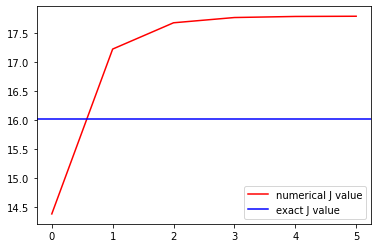

In [ ]:
# Model setiing
# set parameters
T = 0.1
N_step = 100
N_mc = 10
dt = T/N_step
hermiteOrder = 5
# initial
x0 = 2
# coefficience
L = 1
M = 1
C = -10
D = -10
F = 20
R = -0.1
sigma = 1

# Generate a random Wiener process interval
sigma_w = np.sqrt(dt)

# generate a sample of Wt
rng = np.random.default_rng()
dWt = sigma_w*rng.standard_normal(size=(N_mc,N_step))
Wt = np.zeros((N_mc,N_step))
sum_ = 0
for i in range(N_step):
  sum_ += dWt[:,i]
  Wt[:,i] = sum_
# then we calculate the numaricail J value by using functions abouve
J_list_mc = MAS_Wt (T, N_step, N_mc, hermiteOrder, x0, L, M, C, D, F, R, sigma, dWt, Wt)

# calculate the excat solution
S_t = np.zeros(N_step+1)
S_T = R
S_t[0] = S_T
for i in range(N_step):
  s_t = S_T - ((S_T*M + F)/D*(M*S_T + F) - L*S_T - S_T*L - C)*dt

  S_t[i+1] = s_t
  S_T = s_t
S_t = S_t[::-1].reshape(N_step+1,1)

#calculate the integer
int_sigma = 0
for i in range(N_step+1):
  int_sigma += sigma*sigma*S_t[i]*dt

J_exact = x0*S_t[0]*x0 + int_sigma

J_list_mc= np.array(J_list_mc)
print('\n')
print('exact J value : {}'.format(J_exact[0]))
#plot the figure of convergence
plt.plot(range(J_list_mc.shape[0]),J_list_mc, c='r', label = 'numerical J value')
plt.axhline(J_exact[0], c='b', label = 'exact J value')
plt.legend()
plt.show()

### The Fifth Model：
---
The time is : T = 0.1

The number of steps: N_step = 100

The number of steps: N_mc = 10

The initial value of x0: x0 = 100

The value of coefficients: L = 1, M = 1, C = -10, D = -10, F = 20, R = -0.1


**The results**:

1. **Here we change the initial value of x0, and the optimal J changes a lot. From ploting the figure of the exact J value and the numerical J value, we find that this algorithm is gradually converge to a value that a little above the exact values J**.

J is : 32264.625021079002
J is : 38669.40735824521
J is : 39680.815036572116
J is : 39883.208014882046
J is : 39924.22680781617
J is : 39932.527312954066
J is : 39934.20878283163
J is : 39934.54848903291
J is : 39934.61996973184
J is : 39934.63404460061
J is : 39934.63534963281


exact J value : 39607.67011961016


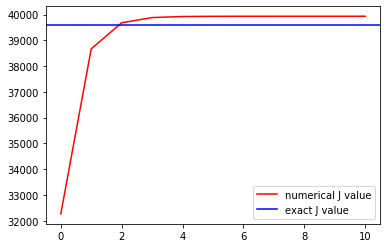

In [ ]:
# Model setiing
# set parameters
T = 0.1
N_step = 100
N_mc = 10
dt = T/N_step
hermiteOrder = 5
# initial
x0 = 100
# coefficience
L = 1
M = 1
C = -10
D = -10
F = 20
R = -0.1
sigma = 0.001

# Generate a random Wiener process interval
sigma_w = np.sqrt(dt)

# generate a sample of Wt
rng = np.random.default_rng()
dWt = sigma_w*rng.standard_normal(size=(N_mc,N_step))
Wt = np.zeros((N_mc,N_step))
sum_ = 0
for i in range(N_step):
  sum_ += dWt[:,i]
  Wt[:,i] = sum_
# then we calculate the numaricail J value by using functions abouve
J_list_mc = MAS_Wt (T, N_step, N_mc, hermiteOrder, x0, L, M, C, D, F, R, sigma, dWt, Wt)

# calculate the excat solution
S_t = np.zeros(N_step+1)
S_T = R
S_t[0] = S_T
for i in range(N_step):
  s_t = S_T - ((S_T*M + F)/D*(M*S_T + F) - L*S_T - S_T*L - C)*dt

  S_t[i+1] = s_t
  S_T = s_t
S_t = S_t[::-1].reshape(N_step+1,1)

#calculate the integer
int_sigma = 0
for i in range(N_step+1):
  int_sigma += sigma*sigma*S_t[i]*dt

J_exact = x0*S_t[0]*x0 + int_sigma

J_list_mc= np.array(J_list_mc)
print('\n')
print('exact J value : {}'.format(J_exact[0]))
#plot the figure of convergence
plt.plot(range(J_list_mc.shape[0]),J_list_mc, c='r', label = 'numerical J value')
plt.axhline(J_exact[0], c='b', label = 'exact J value')
plt.legend()
plt.show()

### The Sixth Model：
---
The time is : T = 0.1

The number of steps: N_step = 100

The number of steps: N_mc = 100

The initial value of x0: x0 = 2

The value of coefficients: L = 1, M = 1, C = -10, D = -10, F = 20, R = -0.1, σ = 0.001


**The results**:


1. **Here we increase the N_mc, and find that we reduce the difference about exact value J and numarical J' from 0.13 to 0.11. so increase the N_mc can increase the accurancy about optimal J, but it cost more time to run the algorithm**.

J is : 12.905593220421322
J is : 15.470185653628219
J is : 15.864249013929069
J is : 15.943065274582157
J is : 15.959054730908997
J is : 15.962291330019493


exact J value : 15.843068221473517


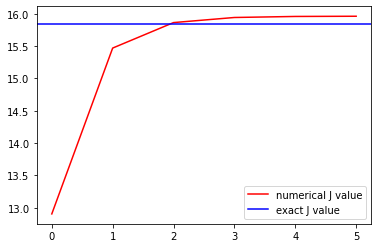

In [ ]:
# Model setiing
# set parameters
T = 0.1
N_step = 100
N_mc = 100
dt = T/N_step
hermiteOrder = 5
# initial
x0 = 2
# coefficience
L = 1
M = 1
C = -10
D = -10
F = 20
R = -0.1
sigma = 0.001

# Generate a random Wiener process interval
sigma_w = np.sqrt(dt)

# generate a sample of Wt
rng = np.random.default_rng()
dWt = sigma_w*rng.standard_normal(size=(N_mc,N_step))
Wt = np.zeros((N_mc,N_step))
sum_ = 0
for i in range(N_step):
  sum_ += dWt[:,i]
  Wt[:,i] = sum_
# then we calculate the numaricail J value by using functions abouve
J_list_mc = MAS_Wt (T, N_step, N_mc, hermiteOrder, x0, L, M, C, D, F, R, sigma, dWt, Wt)

# calculate the excat solution
S_t = np.zeros(N_step+1)
S_T = R
S_t[0] = S_T
for i in range(N_step):
  s_t = S_T - ((S_T*M + F)/D*(M*S_T + F) - L*S_T - S_T*L - C)*dt

  S_t[i+1] = s_t
  S_T = s_t
S_t = S_t[::-1].reshape(N_step+1,1)

#calculate the integer
int_sigma = 0
for i in range(N_step+1):
  int_sigma += sigma*sigma*S_t[i]*dt

J_exact = x0*S_t[0]*x0 + int_sigma

J_list_mc= np.array(J_list_mc)
print('\n')
print('exact J value : {}'.format(J_exact[0]))
#plot the figure of convergence
plt.plot(range(J_list_mc.shape[0]),J_list_mc, c='r', label = 'numerical J value')
plt.axhline(J_exact[0], c='b', label = 'exact J value')
plt.legend()
plt.show()

## Conclusion for Stochastic Linear Quadratic control:
---
We set parameters of Linear Quadratic control to be constant.

We change the problem setting and parameters for many different values, but only four models above:
### Analysis:

(1)For the dependence of problem setting:

Similar as deterministic MSA, as we can see in the three model above:
1. the numarical solution is very sensitive with parameters. For different parameters, the convergence rate , the accurancy of convergence optimal J will change a lot. 
2. the set of initial solution x0 will also affect the convergence rate and the accurancy of convergence optimal J.
3. compare with deterministic Linear Quadratic control, the accurancy of convergence optimal J is decrease, especially with low value of parameter C and D.
4. increase the σ will decrease the accurancy of MSA' numarical optimal J.

(2).For the dependence of parameters choices:
1. we test the dependence of convergence and N_step, and find that, as N_step increase, the accurancy of MSA's numarical optimal J values will increase. 

2. we test the dependence of convergence and N_mc, and find that, as N_mc increase, the accurancy of MSA's numarical optimal J values will increase. 




